In [1]:
#!sudo pip3 install pandas
#!sudo pip3 install sklearn
#!sudo pip3 install graphviz

In [2]:
import pandas as pd

# I. Traitement des données

### 1. Importation du dataset contenant les données débloatées 
(Plusieurs colonnes normalisées (caller_id, opened_by, sys_created_by, sys_updated_by, location, category, subcategory, u_symptom, cmdb_ci, assignement_group, assigned_to, problem_id, rfc, vendor, closed_code, resolved_by ne contiennent plus que des valeurs numériques, sans perte d'information). Les "?" ont été remplacés par des cases vides. 
De plus, les variables de type object ou string ont été converties en float ou int, suivant le cas.

In [3]:
#La colonne "caused_by" a été supprimée car vide
dataset = pd.read_csv("incident_event_log_debloated.csv", sep=',', encoding='UTF-8')
dataset

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,2403.0,397.0,29/2/2016 04:40,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,81.0,1/3/2016 09:52,6/3/2016 10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,116.0,12.0,16/2/2017 09:09,...,False,True,Do Not Notify,NaN,NaN,NaN,9.0,9.0,16/2/2017 09:53,16/2/2017 09:53
141708,INC0121064,Active,True,0,0,0,True,116.0,12.0,16/2/2017 14:17,...,False,False,Do Not Notify,NaN,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38
141709,INC0121064,Active,True,1,0,1,True,116.0,12.0,16/2/2017 14:17,...,False,False,Do Not Notify,NaN,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38
141710,INC0121064,Resolved,True,1,0,2,True,116.0,12.0,16/2/2017 14:17,...,False,True,Do Not Notify,NaN,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38


In [4]:
dataset.dtypes

number                      object
incident_state              object
active                        bool
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                      bool
caller_id                  float64
opened_by                  float64
opened_at                   object
sys_created_by             float64
sys_created_at              object
sys_updated_by               int64
sys_updated_at              object
contact_type                object
location                   float64
category                   float64
subcategory                float64
u_symptom                  float64
cmdb_ci                    float64
impact                      object
urgency                     object
priority                    object
assignment_group           float64
assigned_to                float64
knowledge                     bool
u_priority_confirmation       bool
notify                      object
problem_id          

### 2. Conversion des types de données erronés
On va supprimer certaines colonnes qui sont inutiles pour notre régression, comme l'ID de l'incident et le RFC.
Pandas a également mal interprété le type de données de certaines colonnes, on applique donc une correction.

In [5]:
dataset = dataset.drop(columns="number")
dataset = dataset.drop(columns="rfc")
dataset.active = dataset.active.astype(int)
dataset.made_sla = dataset.made_sla.astype(int)
print(dataset.incident_state.value_counts())
incident_state_dico = {"New":0, "Resolved":1, "Closed":2, "Active":3, "Awaiting User Info":4, "Awaiting Vendor":5, "Awaiting Problem":6, "Awaiting Evidence":7, "-100":8}

Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: incident_state, dtype: int64


In [6]:
#dataset.replace({"incident_state": incident_state_dico})
dataset.incident_state = dataset.incident_state.map(incident_state_dico)

In [7]:
print(dataset.contact_type.value_counts())
contact_type_dico = {"Phone":0, "Self service":1, "Email":2, "IVR":3, "Direct opening":4}
dataset.contact_type = dataset.contact_type.map(contact_type_dico)
dataset.contact_type

Phone             140462
Self service         995
Email                220
IVR                   18
Direct opening        17
Name: contact_type, dtype: int64


0         0
1         0
2         0
3         0
4         0
         ..
141707    2
141708    2
141709    2
141710    2
141711    2
Name: contact_type, Length: 141712, dtype: int64

In [8]:
print(dataset.impact.value_counts())
impact_dico = {"2 - Medium":2, "3 - Low":3, "1 - High":1}
dataset.impact = dataset.impact.map(impact_dico)
dataset.urgency = dataset.urgency.map(impact_dico)

2 - Medium    134335
3 - Low         3886
1 - High        3491
Name: impact, dtype: int64


In [9]:
print(dataset.priority.value_counts())
priority_dico = {"3 - Moderate":3, "4 - Low":4, "2 - High":2, "1 - Critical":1}
dataset.priority = dataset.priority.map(priority_dico)

3 - Moderate    132452
4 - Low           4030
2 - High          2972
1 - Critical      2258
Name: priority, dtype: int64


In [10]:
dataset.knowledge = dataset.knowledge.astype(int)
dataset.u_priority_confirmation = dataset.u_priority_confirmation.astype(int)

In [11]:
print(dataset.notify.value_counts())
notify_dico = {"Do Not Notify":0, "Send Email":1}
dataset.notify = dataset.notify.map(notify_dico)

Do Not Notify    141593
Send Email          119
Name: notify, dtype: int64


In [12]:
print(dataset.vendor.value_counts())
vendor_dico = {"8s":0, "Vendor 1":1, "Vendor 2":2, "Vendor 3":3}
dataset.vendor = dataset.vendor.map(vendor_dico)

8s          167
Vendor 1     69
Vendor 3      6
Vendor 2      2
Name: vendor, dtype: int64


In [13]:
dataset.dtypes

incident_state               int64
active                       int64
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                     int64
caller_id                  float64
opened_by                  float64
opened_at                   object
sys_created_by             float64
sys_created_at              object
sys_updated_by               int64
sys_updated_at              object
contact_type                 int64
location                   float64
category                   float64
subcategory                float64
u_symptom                  float64
cmdb_ci                    float64
impact                       int64
urgency                      int64
priority                     int64
assignment_group           float64
assigned_to                float64
knowledge                    int64
u_priority_confirmation      int64
notify                       int64
problem_id                 float64
vendor              

In [14]:
dataset.shape

(141712, 33)

### 3. On cherche le temps de résolution pour chaque ligne
Pour chaque ligne, on calcule la différence de temps entre la résolution et l'ouverture de l'incident. Ces informations sont rangées dans une liste de la même longueur que le dataset.

In [15]:
Y_list = list()
def resolved_time(row):    
    cols = ['opened_at','closed_at']
    #cols = ['opened_at','resolved_at']
    opened_at = pd.to_datetime(row[cols[0]])
    closed_at = pd.to_datetime(row[cols[1]])
    #resolved_at = pd.to_datetime(row[cols[1]])
    
    time_completion = (closed_at - opened_at)
    #time_completion = (resolved_at - opened_at)
    
    #if time_completion > datetime.timedelta(seconds=0): 
    #    Y_list.append(time_completion)
    #else:
    #    Y_list.append(-1)
    Y_list.append(time_completion)
    
    
for index, row in dataset.iterrows():
    resolved_time(row)

In [16]:
len(Y_list)


141712

In [17]:
Y_list

[Timedelta('64 days 10:44:00'),
 Timedelta('64 days 10:44:00'),
 Timedelta('64 days 10:44:00'),
 Timedelta('64 days 10:44:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Tim

### 4. On controle s'il y a des valeurs négatives. Nous allons donc remplacer ces valeurs négatives par "-1" afin d'avoir des données logiques.

In [18]:
import numpy as np
import datetime
minutesList = list()
length = len(dataset) 
for i in range(length):
    if Y_list[i] > datetime.timedelta(seconds=0):
        minutesList.append(Y_list[i].total_seconds()/60)
    else:
        minutesList.append(-1)

duration = np.ravel(pd.DataFrame(minutesList))
duration[:20]
dataset["resolved_in"] = duration

In [19]:
dataset.dtypes

incident_state               int64
active                       int64
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                     int64
caller_id                  float64
opened_by                  float64
opened_at                   object
sys_created_by             float64
sys_created_at              object
sys_updated_by               int64
sys_updated_at              object
contact_type                 int64
location                   float64
category                   float64
subcategory                float64
u_symptom                  float64
cmdb_ci                    float64
impact                       int64
urgency                      int64
priority                     int64
assignment_group           float64
assigned_to                float64
knowledge                    int64
u_priority_confirmation      int64
notify                       int64
problem_id                 float64
vendor              

### 5. On garde seulement les incidents ayant pour statut "Resolved"

In [20]:
resolved_temp = dataset.loc[dataset.incident_state == 1]
dataset = pd.DataFrame(resolved_temp)
dataset = dataset.reset_index(drop=True)

On garde seulement les lignes ayant une valeur correcte pour resolved_in

In [21]:
resolved_temp = dataset.loc[dataset.resolved_in != -1]
dataset = pd.DataFrame(resolved_temp)
dataset = dataset.reset_index(drop=True)

In [22]:
dataset

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,...,knowledge,u_priority_confirmation,notify,problem_id,vendor,closed_code,resolved_by,resolved_at,closed_at,resolved_in
0,1,1,0,0,2,1,2403.0,8.0,29/2/2016 01:16,6.0,...,1,0,0,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00,92804.0
1,1,1,0,0,3,1,2403.0,8.0,29/2/2016 01:16,6.0,...,1,0,0,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00,92804.0
2,1,1,1,0,7,1,2403.0,397.0,29/2/2016 04:40,171.0,...,1,0,0,NaN,NaN,5.0,81.0,1/3/2016 09:52,6/3/2016 10:00,137120.0
3,1,1,0,0,5,1,4416.0,8.0,29/2/2016 06:10,NaN,...,1,0,0,2.0,NaN,10.0,5.0,1/3/2016 02:55,6/3/2016 03:00,136610.0
4,1,1,0,0,2,1,4491.0,180.0,29/2/2016 06:38,81.0,...,1,0,0,NaN,NaN,3.0,113.0,2/3/2016 12:06,7/3/2016 13:00,180382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16823,1,1,1,0,2,1,116.0,12.0,10/2/2017 14:11,NaN,...,0,1,0,NaN,NaN,6.0,9.0,10/2/2017 17:27,10/2/2017 17:27,196.0
16824,1,1,3,0,5,1,5100.0,490.0,13/2/2017 10:33,NaN,...,0,1,0,NaN,NaN,6.0,166.0,14/2/2017 09:37,14/2/2017 12:08,1535.0
16825,1,1,0,0,1,1,90.0,8.0,15/2/2017 02:02,NaN,...,0,1,0,NaN,NaN,6.0,5.0,17/2/2017 00:47,17/2/2017 00:50,2808.0
16826,1,1,1,0,3,1,116.0,12.0,16/2/2017 09:09,NaN,...,0,1,0,NaN,NaN,9.0,9.0,16/2/2017 09:53,16/2/2017 09:53,44.0


Après avoir trouvé ces temps, on va convertir les colonnes de type date (en string) en float.

In [23]:
dataset.opened_at = dataset.opened_at.str.replace("/","")
dataset.sys_created_at = dataset.sys_created_at.str.replace("/","")
dataset.sys_updated_at = dataset.sys_updated_at.str.replace("/","")
dataset.resolved_at = dataset.resolved_at.str.replace("/","")
dataset.closed_at = dataset.closed_at.str.replace("/","")

dataset.opened_at = dataset.opened_at.str.replace(" ","")
dataset.sys_created_at = dataset.sys_created_at.str.replace(" ","")
dataset.sys_updated_at = dataset.sys_updated_at.str.replace(" ","")
dataset.resolved_at = dataset.resolved_at.str.replace(" ","")
dataset.closed_at = dataset.closed_at.str.replace(" ","")

dataset.opened_at = dataset.opened_at.str.replace(":","")
dataset.sys_created_at = dataset.sys_created_at.str.replace(":","")
dataset.sys_updated_at = dataset.sys_updated_at.str.replace(":","")
dataset.resolved_at = dataset.resolved_at.str.replace(":","")
dataset.closed_at = dataset.closed_at.str.replace(":","")

dataset.opened_at = dataset.opened_at.astype(float)
dataset.sys_created_at = dataset.sys_created_at.astype(float)
dataset.sys_updated_at = dataset.sys_updated_at.astype(float)
dataset.resolved_at = dataset.resolved_at.astype(float)
dataset.closed_at = dataset.closed_at.astype(float)

### 6. On regarde si certaines colonnes ont trop de valeurs manquantes (et ne sont donc pas utilisables). Si plus de 30% des données de la colonne sont manquantes, on la supprime.

In [24]:
import math
total = len(dataset["incident_state"])
#print(dataset["vendor"][3])
for column in dataset.columns:
    v = 0
    for i in range(total):
        if dataset[column][i] == None:
            v+=1
        elif dataset[column].dtype == int or dataset[column].dtype == float:
            if math.isnan(dataset[column][i]):
                v+=1
    if v/total*100 > 30:
        print("Column name: ", column, " ; Empty: ", v/total*100, "%")
        dataset = dataset.drop(columns=column)
dataset.dtypes

Column name:  sys_created_by  ; Empty:  46.678155455193725 %
Column name:  sys_created_at  ; Empty:  46.678155455193725 %
Column name:  cmdb_ci  ; Empty:  99.8098407416211 %
Column name:  problem_id  ; Empty:  98.19942952222488 %
Column name:  vendor  ; Empty:  99.92274780128358 %


incident_state               int64
active                       int64
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                     int64
caller_id                  float64
opened_by                  float64
opened_at                  float64
sys_updated_by               int64
sys_updated_at             float64
contact_type                 int64
location                   float64
category                   float64
subcategory                float64
u_symptom                  float64
impact                       int64
urgency                      int64
priority                     int64
assignment_group           float64
assigned_to                float64
knowledge                    int64
u_priority_confirmation      int64
notify                       int64
closed_code                float64
resolved_by                float64
resolved_at                float64
closed_at                  float64
resolved_in         

# II. Régressions

### 1. Si on a des valeurs infinies dans le dataset, elles sont remplacées par NaN. Ensuite, les valeurs NaN du dataset sont remplacées par une moyenne.

In [25]:
dataset[dataset==np.inf]=np.nan
dataset.fillna(dataset.mean(), inplace=True)

### 2. On crée nos X et Y en supprimant les colonnes nécessaires

In [26]:
y = dataset.resolved_in
x = dataset.drop('resolved_in', axis=1)
x = x.drop('resolved_at', axis=1)
x = x.drop('closed_at', axis=1)
x = x.drop('opened_at', axis=1)
#x = x.drop('sys_updated_at', axis=1)

In [27]:
dataset

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_updated_by,...,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at,resolved_in
0,1,1,0,0,2,1,2403.0,8.0,2.922016e+10,642,...,56.0,100.542242,1,0,0,5.0,149.0,2.922016e+10,5.320161e+09,92804.0
1,1,1,0,0,3,1,2403.0,8.0,2.922016e+10,804,...,56.0,100.542242,1,0,0,5.0,149.0,2.922016e+10,5.320161e+09,92804.0
2,1,1,1,0,7,1,2403.0,397.0,2.922016e+10,332,...,24.0,89.000000,1,0,0,5.0,81.0,1.320161e+09,6.320161e+09,137120.0
3,1,1,0,0,5,1,4416.0,8.0,2.922016e+10,21,...,70.0,6.000000,1,0,0,10.0,5.0,1.320160e+09,6.320160e+09,136610.0
4,1,1,0,0,2,1,4491.0,180.0,2.922016e+10,465,...,25.0,125.000000,1,0,0,3.0,113.0,2.320161e+09,7.320161e+09,180382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16823,1,1,1,0,2,1,116.0,12.0,1.022017e+10,27,...,31.0,10.000000,0,1,0,6.0,9.0,1.022017e+10,1.022017e+10,196.0
16824,1,1,3,0,5,1,5100.0,490.0,1.322017e+10,699,...,39.0,36.000000,0,1,0,6.0,166.0,1.422017e+10,1.422017e+10,1535.0
16825,1,1,0,0,1,1,90.0,8.0,1.522017e+10,21,...,64.0,6.000000,0,1,0,6.0,5.0,1.722017e+10,1.722017e+10,2808.0
16826,1,1,1,0,3,1,116.0,12.0,1.622017e+10,27,...,31.0,10.000000,0,1,0,9.0,9.0,1.622017e+10,1.622017e+10,44.0


In [28]:
x

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,sys_updated_by,sys_updated_at,...,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by
0,1,1,0,0,2,1,2403.0,8.0,642,2.922016e+10,...,2,2,3,56.0,100.542242,1,0,0,5.0,149.0
1,1,1,0,0,3,1,2403.0,8.0,804,2.922016e+10,...,2,2,3,56.0,100.542242,1,0,0,5.0,149.0
2,1,1,1,0,7,1,2403.0,397.0,332,1.320161e+09,...,2,2,3,24.0,89.000000,1,0,0,5.0,81.0
3,1,1,0,0,5,1,4416.0,8.0,21,1.320160e+09,...,2,2,3,70.0,6.000000,1,0,0,10.0,5.0
4,1,1,0,0,2,1,4491.0,180.0,465,2.320161e+09,...,2,2,3,25.0,125.000000,1,0,0,3.0,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16823,1,1,1,0,2,1,116.0,12.0,27,1.022017e+10,...,2,2,3,31.0,10.000000,0,1,0,6.0,9.0
16824,1,1,3,0,5,1,5100.0,490.0,699,1.422017e+10,...,2,2,3,39.0,36.000000,0,1,0,6.0,166.0
16825,1,1,0,0,1,1,90.0,8.0,21,1.722017e+10,...,2,2,3,64.0,6.000000,0,1,0,6.0,5.0
16826,1,1,1,0,3,1,116.0,12.0,27,1.622017e+10,...,2,2,3,31.0,10.000000,0,1,0,9.0,9.0


### 3. On sépare nos données en un dataset de train et de test

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2, random_state=0)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((13462, 25), (3366, 25), (13462,), (3366,))

### 4. On réinitialise les index de test afin de pouvoir avoir des plots propres

In [30]:
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

### 5. Decision Tree Regressor

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
#cross_val_score(regressor, X_train, Y_train, cv=10)
regressor.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [32]:
importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [33]:
regressor.score(X_test, Y_test)

0.7605244831329354

In [34]:
y_pred = regressor.predict(X_test)

In [35]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':y_pred})
df

,Actual,Predicted
0,94286.0,260732.0
1,217522.0,217876.0
2,8574.0,9845.0
3,220385.0,220481.0
4,220377.0,220352.0
...,...,...
3361,29037.0,27793.0
3362,8880.0,346.0
3363,265188.0,306504.0
3364,220353.0,220332.0


In [36]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 21559.476661084205
Mean Squared Error: 2932912784.5534277
Root Mean Squared Error: 54156.373443514734


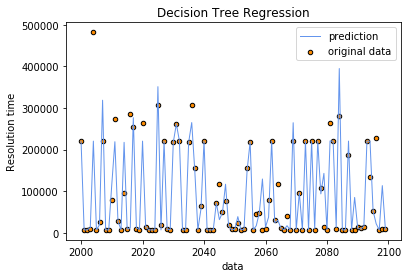

In [37]:

import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2000:2100], Y_test[2000:2100], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2000:2100], y_pred[2000:2100], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### 6. Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor



randomForestRegressor = RandomForestRegressor(n_estimators=150,random_state=100)
randomForestRegressor.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

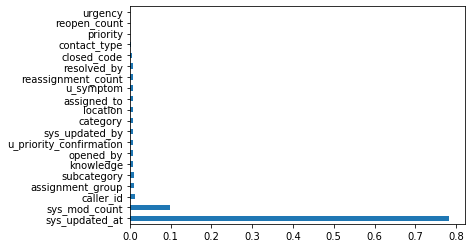

In [39]:
importances = pd.Series(randomForestRegressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [40]:
randomForestRegressor.score(X_test, Y_test)

0.8880287968001366

In [41]:
yRFR = randomForestRegressor.predict(X_test)

In [42]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':yRFR})
df

,Actual,Predicted
0,94286.0,211436.466667
1,217522.0,207909.166667
2,8574.0,15342.213333
3,220385.0,221310.193333
4,220377.0,221877.080000
...,...,...
3361,29037.0,64655.140000
3362,8880.0,14981.981481
3363,265188.0,295520.513333
3364,220353.0,220351.266667


In [43]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, yRFR))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, yRFR))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, yRFR)))

Mean Absolute Error: 17037.12748174754
Mean Squared Error: 1371337569.9654875
Root Mean Squared Error: 37031.57531034141


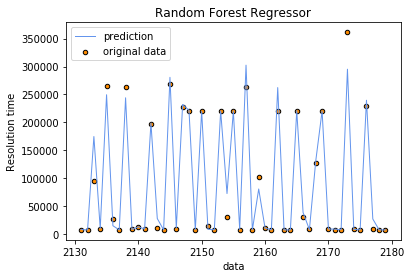

In [44]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], yRFR[2131:2180], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("Random Forest Regressor")
plt.legend()
plt.show()

### 7. Support Vector Regression

SVR Linear (Ne fonctionne pas)

SVR RBF

In [45]:
from sklearn.svm import SVR
rbfRegressor = SVR(kernel='rbf', epsilon=1.0)
rbfRegressor.fit(X_train, Y_train)
yRBF = rbfRegressor.predict(X_test)

In [46]:
rbfRegressor.score(X_test, Y_test)

-0.4425326532092695

In [47]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':yRBF})
df

,Actual,Predicted
0,94286.0,24129.834975
1,217522.0,24022.833344
2,8574.0,20391.202580
3,220385.0,23207.622415
4,220377.0,23391.724444
...,...,...
3361,29037.0,22377.338525
3362,8880.0,21151.457114
3363,265188.0,23742.486299
3364,220353.0,23727.017022


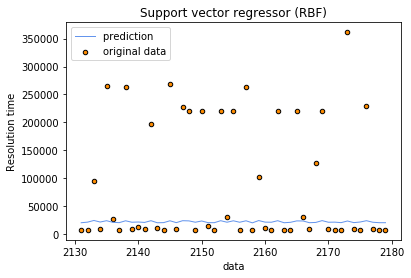

In [48]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], yRBF[2131:2180], color="cornflowerblue",
         label="prediction ", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("Support vector regressor (RBF)")
plt.legend()
plt.show()

### 8. AdaBoost Regressor

In [49]:
from sklearn.ensemble import AdaBoostRegressor

adaBoostRegressor = AdaBoostRegressor(n_estimators=150,random_state=0)
adaBoostRegressor.fit(X_train,Y_train)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=150, random_state=0)

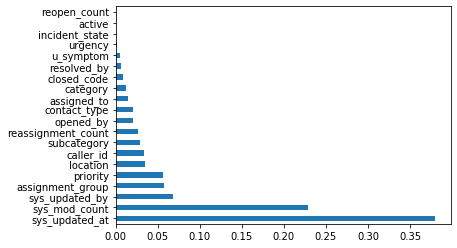

In [50]:
importances = pd.Series(adaBoostRegressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [51]:
adaBoostRegressor.score(X_test, Y_test)

0.5117329272510065

In [52]:
yAda = adaBoostRegressor.predict(X_test)

In [53]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':yAda})
df

,Actual,Predicted
0,94286.0,205007.833828
1,217522.0,205007.833828
2,8574.0,98435.716675
3,220385.0,247600.807442
4,220377.0,238102.110286
...,...,...
3361,29037.0,140806.313034
3362,8880.0,98435.716675
3363,265188.0,225540.498226
3364,220353.0,238102.110286


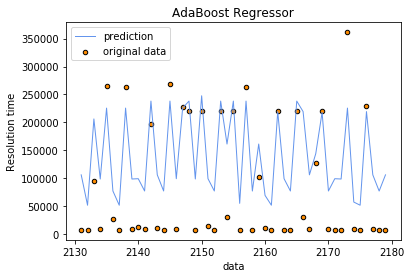

In [54]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], yAda[2131:2180], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("AdaBoost Regressor")
plt.legend()
plt.show()

### 9. GradientBoost Regressor

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoostRegressor = GradientBoostingRegressor(random_state=1, n_estimators=150)
gradientBoostRegressor.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

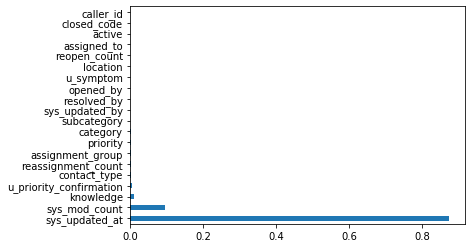

In [56]:
importances = pd.Series(gradientBoostRegressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [57]:
gradientBoostRegressor.score(X_test, Y_test)

0.8782131043051575

In [58]:
yGrad = gradientBoostRegressor.predict(X_test)

In [59]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':yGrad})
df

,Actual,Predicted
0,94286.0,197444.071363
1,217522.0,227506.310769
2,8574.0,16557.610836
3,220385.0,247018.270397
4,220377.0,239227.627210
...,...,...
3361,29037.0,72742.260258
3362,8880.0,14772.821075
3363,265188.0,238350.161345
3364,220353.0,227212.127387


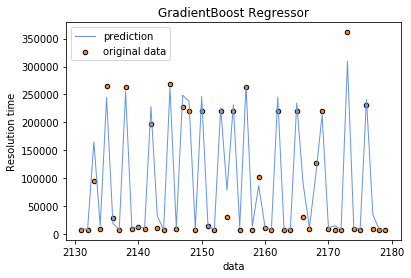

In [60]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], yGrad[2131:2180], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("GradientBoost Regressor")
plt.legend()
plt.show()

# III. Résultats finaux

### 1. Comparaison des différents modèles

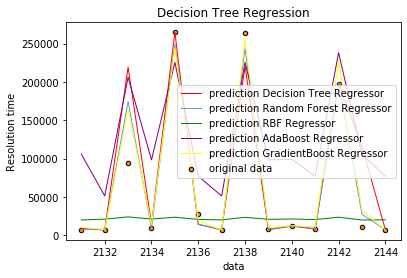

In [61]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2145], Y_test[2131:2145], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2145], y_pred[2131:2145], color="red",
         label="prediction Decision Tree Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], yRFR[2131:2145], color="cornflowerblue",
         label="prediction Random Forest Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], yRBF[2131:2145], color="green",
         label="prediction RBF Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], yAda[2131:2145], color="purple",
         label="prediction AdaBoost Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], yGrad[2131:2145], color="yellow",
         label="prediction GradientBoost Regressor", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Sur ce graphe assez réduit, RBF et AdaBoost ont les résultats les plus éloignés de la réalité.

Comparons les scores:

In [62]:
print("Decision Tree Regressor: ", regressor.score(X_test, Y_test))
print("Random Forest Regressor: ", randomForestRegressor.score(X_test, Y_test))
print("RBF Regressor: ", rbfRegressor.score(X_test, Y_test))
print("AdaBoost Regressor: ", adaBoostRegressor.score(X_test, Y_test))
print("GradientBoost Regressor: ", gradientBoostRegressor.score(X_test, Y_test))


Decision Tree Regressor:  0.7605244831329354
Random Forest Regressor:  0.8880287968001366
RBF Regressor:  -0.4425326532092695
AdaBoost Regressor:  0.5117329272510065
GradientBoost Regressor:  0.8782131043051575


Ces résultats viennent confirmer le ressenti du graphe: Les scores les plus élevés sont Random Forest et Gradient Boost.